In [8]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision import transforms
from ultralytics import YOLO
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage

class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=43):  # GTSRB has 43 classes
        super(TrafficSignCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Fourth convolutional block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)
        
        # Fully connected layers - assuming input images are 32x32
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Block 1
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        
        # Block 2
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        
        # Block 3
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        
        # Block 4
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        
        # Flatten
        x = x.view(-1, 256 * 2 * 2)
        
        # Fully connected with dropout
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

def load_sign_names():
    """
    Load sign names for the GTSRB dataset (43 classes)
    """
    sign_names = {
        0: "Speed limit (20km/h)",
        1: "Speed limit (30km/h)",
        2: "Speed limit (50km/h)",
        3: "Speed limit (60km/h)",
        4: "Speed limit (70km/h)",
        5: "Speed limit (80km/h)",
        6: "End of speed limit (80km/h)",
        7: "Speed limit (100km/h)",
        8: "Speed limit (120km/h)",
        9: "No passing",
        10: "No passing for vehicles over 3.5 metric tons",
        11: "Right-of-way at the next intersection",
        12: "Priority road",
        13: "Yield",
        14: "Stop",
        15: "No vehicles",
        16: "Vehicles over 3.5 metric tons prohibited",
        17: "No entry",
        18: "General caution",
        19: "Dangerous curve to the left",
        20: "Dangerous curve to the right",
        21: "Double curve",
        22: "Bumpy road",
        23: "Slippery road",
        24: "Road narrows on the right",
        25: "Road work",
        26: "Traffic signals",
        27: "Pedestrians",
        28: "Children crossing",
        29: "Bicycles crossing",
        30: "Beware of ice/snow",
        31: "Wild animals crossing",
        32: "End of all speed and passing limits",
        33: "Turn right ahead",
        34: "Turn left ahead",
        35: "Ahead only",
        36: "Go straight or right",
        37: "Go straight or left",
        38: "Keep right",
        39: "Keep left",
        40: "Roundabout mandatory",
        41: "End of no passing",
        42: "End of no passing by vehicles over 3.5 metric tons"
    }
    return sign_names

# Initialize models globally for notebook use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo_model = YOLO("runs/detect/train/weights/best.pt")
cnn_model = TrafficSignCNN()
cnn_model.load_state_dict(torch.load("best_traffic_sign_model.pth", map_location=device))
cnn_model.to(device)
cnn_model.eval()
sign_names = load_sign_names()

# Define transformations for CNN input
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
])

def process_traffic_sign_image(image_path):
    """
    Process an image through YOLO and CNN models for traffic sign detection and classification
    Only displays the results without saving files
    """
    # Load image
    if isinstance(image_path, str):
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not load image at {image_path}")
            return
    else:
        # Assuming image_path is a numpy array/OpenCV image
        image = image_path
    
    # Copy image for annotation
    annotated_img = image.copy()
    
    # Run YOLO detection
    results = yolo_model(image)
    
    # Process each detection
    sign_crops = []
    sign_labels = []
    
    if len(results) > 0:
        boxes = results[0].boxes
        
        for i, box in enumerate(boxes):
            # Get coordinates
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            
            # Draw bounding box on the annotated image
            cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Crop the sign
            sign_crop = image[y1:y2, x1:x2]
            sign_crops.append(sign_crop)
            
            # Prepare for classification
            pil_img = Image.fromarray(cv2.cvtColor(sign_crop, cv2.COLOR_BGR2RGB))
            input_tensor = transform(pil_img).unsqueeze(0).to(device)
            
            # Classify the sign
            with torch.no_grad():
                output = cnn_model(input_tensor)
                _, predicted = torch.max(output, 1)
                class_id = predicted.item()
            
            # Get sign name
            sign_name = sign_names.get(class_id, f"Unknown ({class_id})")
            sign_labels.append(sign_name)
            
            # Add classification result to the annotated image
            label = f"{sign_name}"
            
            # Calculate font scale based on image size
            text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
            if y1 < text_size[1] + 10:
                # If there's not enough space above the bounding box, put the text inside at the top
                text_position = (x1 + 5, y1 + text_size[1] + 5)
            else:
                # Otherwise put it above
                text_position = (x1, y1 - 10)
                
            cv2.putText(annotated_img, label, text_position, cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, (0, 255, 0), 2)
    
    # Display the results
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Traffic Sign Detection & Classification Results")
    plt.show()
    
    # Show individual crops if any
    if sign_crops:
        plt.figure(figsize=(15, 3))
        for i, (crop, label) in enumerate(zip(sign_crops, sign_labels)):
            plt.subplot(1, len(sign_crops), i+1)
            plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(label, fontsize=8)  # Using the actual sign name instead of "Sign X"
        plt.tight_layout()
        plt.show()


0: 288x640 1 sign detected, 24.3ms
Speed: 4.3ms preprocess, 24.3ms inference, 4.9ms postprocess per image at shape (1, 3, 288, 640)


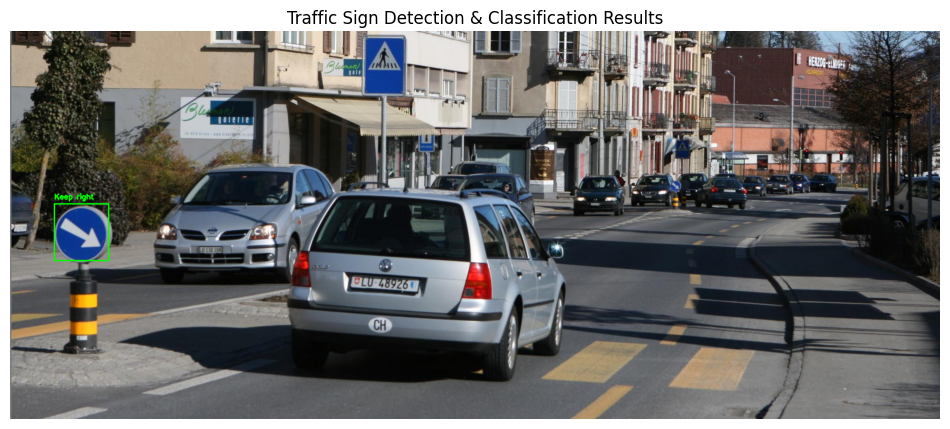

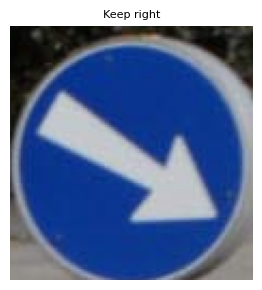


0: 352x640 2 sign detecteds, 24.7ms
Speed: 2.7ms preprocess, 24.7ms inference, 3.5ms postprocess per image at shape (1, 3, 352, 640)


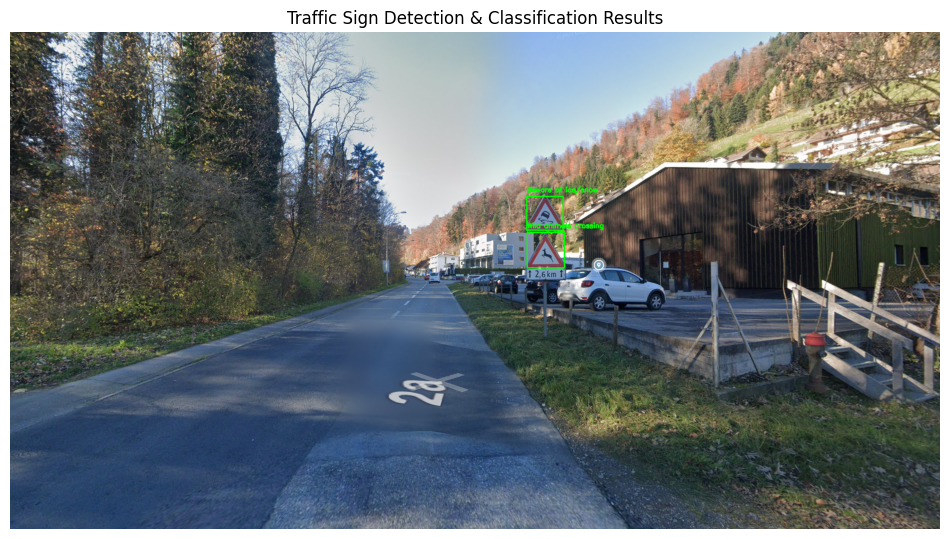

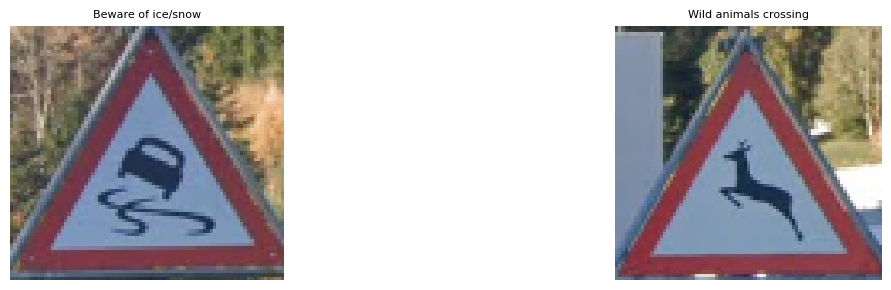


0: 448x640 7 sign detecteds, 22.3ms
Speed: 2.0ms preprocess, 22.3ms inference, 12.8ms postprocess per image at shape (1, 3, 448, 640)


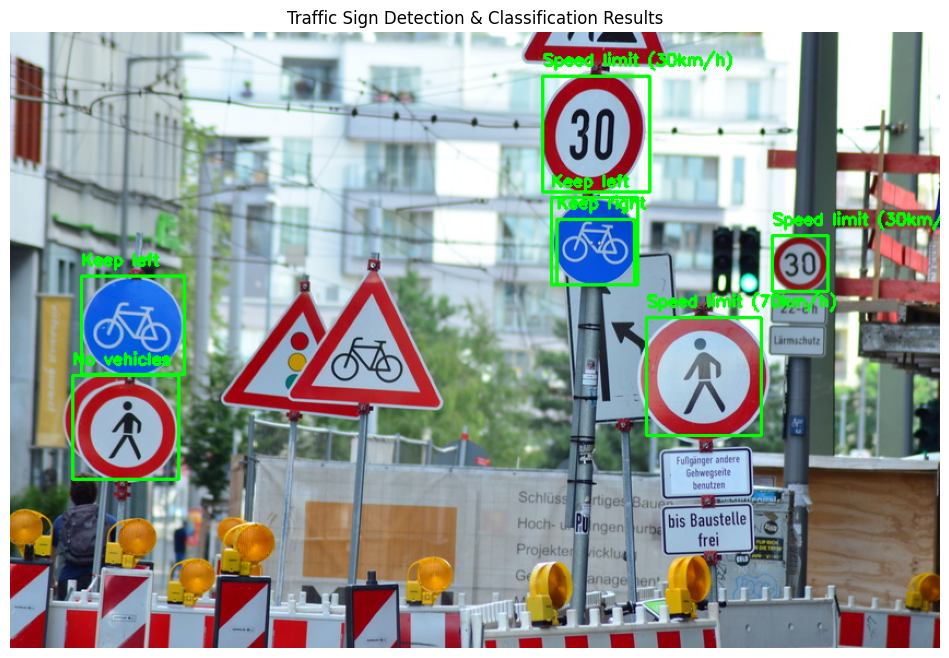

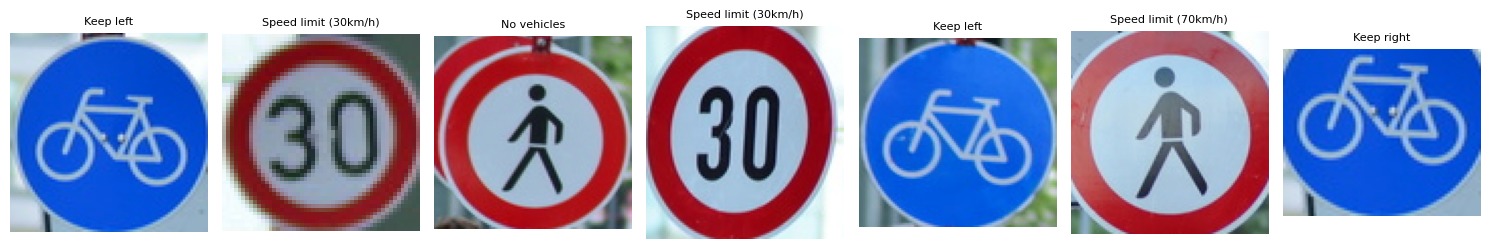

In [13]:
# Example usage with a file path
for image in os.listdir("test_images"):
    if image.endswith(('.jpg', '.png', '.jpeg')):
        image_path = os.path.join("test_images", image)
        process_traffic_sign_image(image_path)